In [90]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
import math
from scipy.optimize import curve_fit
from collections import deque, defaultdict
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [123]:
def connectivityExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    connectivity_raw = data_structure['connectivity'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    connectivity_data = connectivity_raw.squeeze()
    # Create a DataFrame from the connectivity data
    connectivity_df = pd.DataFrame(connectivity_data, columns=['Parent', 'Daughter1', 'Daughter2', 'Daughter3'])
    connectivity_df.replace(0, np.nan, inplace=True) #ensure all nonexistent vessels have NaN
    connectivity_df.at[0,'Parent']=0 #make sure first vessel is 0 (purposefully removed in last step for ease)
    # Save the DataFrame to inspect it
    return connectivity_df

def lengthExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'lengths' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    length_raw = data_structure['lengths'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    length_data = length_raw.squeeze()
    # Create a DataFrame from the data
    length_df = pd.DataFrame(length_data, columns=['Length'])
    # Save the DataFrame to inspect it
    return length_df

def radiusExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'radius' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    radius_raw = data_structure['rin'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    radius_data = radius_raw.squeeze()
    # Create a DataFrame from the data
    radius_df = pd.DataFrame(radius_data, columns=['Radius'])
    # Save the DataFrame to inspect it
    return radius_df

def volumeExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name + '.mat'
    matlab_data = scipy.io.loadmat(file_path)
    volume_raw = matlab_data['volumes']  # This is an x by 1 or 1D array
    volume_data = volume_raw.squeeze()  # Converts to 1D array if it's still 2D with 1 column
    volume_df = pd.DataFrame(volume_data, columns=['Volume'])
    return volume_df

def lRR(data):
    lrr = np.empty((0,0))
    for i in np.arange(data.shape[0]): #iterate over every vessel
        length = data.iloc[i]['Length'] #pull the length value
        radius = data.iloc[i]['Radius'] #retreive radius value
        lrr_value = length/radius #calculate lrr
        lrr = np.append(lrr,lrr_value) #append lrr value to total list
    data['Length/Radius'] = lrr.tolist() #add list to table
    return data

def assignDepth(data):
    tree = {} 
    for _, row in data.iterrows(): #iterate over every row
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist() #only select daughter values that exist
        tree[parent] = daughters
    # Step 2: BFS traversal to assign depths
    depths = {}
    queue = deque([(data['Parent'].iloc[0], 0)])  # Start from root (first parent)

    while queue:
        node, depth = queue.popleft()
        depths[node] = depth
        for child in tree.get(node, []):
            if child not in depths:  # Avoid revisiting
                queue.append((child, depth + 1))
    data['Depth'] = data['Parent'].map(depths)
    return data

def lengthFromRoot(data):
    tree = {}
    length_dict = dict(zip(data['Parent'], data['Length']))  # Map each vessel (parent) to its length

    for _, row in data.iterrows():
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist()
        tree[parent] = daughters

    # BFS traversal to calculate cumulative lengths
    lengths = {}
    root = data['Parent'].iloc[0]
    queue = deque([(root, 0)])  # Start with cumulative length 0

    while queue:
        node, cum_length = queue.popleft()
        lengths[node] = cum_length
        for child in tree.get(node, []):
            if child not in lengths:  # Avoid revisiting
                additional_length = length_dict.get(child, 0)
                queue.append((child, cum_length + additional_length))

    data['LengthFromRoot'] = data['Parent'].map(lengths)
    return data

def nodesExtractor(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'nodes' field
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractor(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'segments' field
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def mapIDExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'mapID' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    map_raw = data_structure['mapIDs'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    map_data = map_raw.squeeze()
    # Create a DataFrame from the connectivity data
    map_df = pd.DataFrame(map_data, columns=['New', 'Old'])
    # Save the DataFrame to inspect it
    return map_df

def tortuosityCalculator(data,name):
    nodes = nodesExtractor(name)
    edges = edgesExtractor(name)
    maps = mapIDExtractor(name)
    tortuosity = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        old_vesID = maps.iloc[i]['Old'] #find the old vessel ID
        edge_row = edges.index.get_loc(edges[edges['ID'] == old_vesID].index[0])
        node1 = edges.iloc[edge_row]['From'] #identify from node
        node2 = edges.iloc[edge_row]['To'] #identify to node
        node1_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node1].index[0])
        node2_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node2].index[0])
        node1_x = nodes.iloc[node1_row]['X'] #pull node 3d coordinate
        node1_y = nodes.iloc[node1_row]['Y']
        node1_z = nodes.iloc[node1_row]['Z']
        node2_x = nodes.iloc[node2_row]['X']
        node2_y = nodes.iloc[node2_row]['Y']
        node2_z = nodes.iloc[node2_row]['Z']
        euclid_dist = math.sqrt((node1_x - node2_x)**2 + (node1_y - node2_y)**2 + (node1_z - node2_z)**2) #calculate euclidean distance between from and to
        length = data.iloc[i]['Length'] #pull length and convert to mm
        ratio = length/euclid_dist #find tortuosity ratio
        tortuosity = np.append(tortuosity,ratio)
    data['Tortuosity'] = tortuosity.tolist() #add to table
    return data

def radiusFinder(data):
    dv1r = np.empty((0,0))
    dv2r = np.empty((0,0))
    dv3r = np.empty((0,0))
    for i in np.arange(data.shape[0]):# iterate over every row
        dv1 = data.iloc[i]['Daughter1'] #pull radii values
        dv2 = data.iloc[i]['Daughter2']
        dv3 = data.iloc[i]['Daughter3']
        if math.isnan(dv1): #if daughter vessel 1 doesn't exist, none of them do
            dv1r = np.append(dv1r,np.nan)
            dv2r = np.append(dv2r,np.nan)
            dv3r = np.append(dv3r,np.nan)
            continue
        dv1r = np.append(dv1r,data.iloc[int(dv1)][2])
        dv2r = np.append(dv2r,data.iloc[int(dv2)][2])
        if math.isnan(dv3): #explicitly check whetehr dv3 exist
            dv3r = np.append(dv3r,np.nan)
            continue
        dv3r = np.append(dv3r,data.iloc[int(dv3)][2])
    data['DV1R'] = dv1r.tolist()
    data['DV2R'] = dv2r.tolist()
    data['DV3R'] = dv3r.tolist()
    #select and reorder columns
    data = data.loc[:,['Parent','Depth','Length','Radius','Volume', 'Length/Radius','LengthFromRoot','Tortuosity','Daughter1','DV1R','Daughter2','DV2R','Daughter3','DV3R']]
    return data

def alphaBeta(data):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #check if trifurcation, if it is then don't calculate
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R']
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #check if daughter vessels exist
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        if dv1r>=dv2r: #case 1 of daughter vessels
            alpha_value = dv1r/pv
            beta_value = dv2r/pv
        else: #case 2 of daughter vessels
            alpha_value = dv2r/pv
            beta_value = dv1r/pv
        alpha = np.append(alpha,alpha_value)
        beta = np.append(beta,beta_value)
    data['Alpha'] = alpha.tolist() #add alpha and beta to total table
    data['Beta'] = beta.tolist()
    return data

def xiFinder(data):
    xi_values = np.empty((0,0))
    error_values = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        rp = data.iloc[i]['Radius'] #pull all radii
        rd1 = data.iloc[i]['DV1R']
        rd2 = data.iloc[i]['DV2R']
        rd3 = data.iloc[i]['DV3R']
        if not math.isnan(rd3): #don't calculate if trifucation
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        if math.isnan(rd1): #don't calculate if no daughter vessels
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        while abs(error) > 1e-4: #allow for error up to 10^-4
            fun = rp**xi - rd1**xi - rd2**xi # solve at f(xi)
            fun2 = (rp**xi)*math.log(rp) - (rd1**xi)*math.log(rd1) - (rd2**xi)*math.log(rd2) #solve at f'(xi)
            xi = xi - fun/fun2 # new xi value
            error = rp**xi - rd1**xi - rd2**xi #calculate new error
        if xi > 6: #bound xi
            xi = 6
        if xi < 1:
            xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        xi_values = np.append(xi_values,xi)
        error_values = np.append(error_values,error)
    data['Xi'] = xi_values.tolist()#add xi to the table
    #data['Error Newton'] = error_values.tolist()
    return data

def asymmetry(data):
    asym = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #don't calculate if trifucation
            asym = np.append(asym,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull radii
        dv2r = data.iloc[i]['DV2R']
        if math.isnan(dv1r): #if no daughters, skip
            asym = np.append(asym,np.nan)
            continue
        if dv1r>=dv2r: #case 1
            asym_value = (dv2r/dv1r)**2
        else: #case 2
            asym_value = (dv1r/dv2r)**2
        asym = np.append(asym,asym_value)
    data['Gamma'] = asym.tolist() #add to table
    return data

def area(data):
    area = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #if trifucation, skip
            area = np.append(area,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull necessary radii
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #if no daughters, skip
            area = np.append(area,np.nan)
            continue
        area_value = (dv1r**2+dv2r**2)/(pv**2) #calculate eta
        area = np.append(area,area_value)
    data['Eta'] = area.tolist() #add to table
    return data

def dataExtractor(name): #sequentially calls necessary functions to create full table
    connectivity = connectivityExtractor(name)
    length = lengthExtractor(name)
    radius = radiusExtractor(name)
    volume = volumeExtractor(name)
    combined = pd.concat([connectivity.iloc[:, :1], length, radius, volume, connectivity.iloc[:, 1:]], axis=1)
    lengthradius = lRR(combined)
    #print('LRR')
    depthness = assignDepth(lengthradius)
    #print('Depth')
    lengthTotal = lengthFromRoot(depthness)
    #print('LengthFromRoot')
    tortuos = tortuosityCalculator(lengthTotal,name)
    #print('Tortousity')
    allradii = radiusFinder(tortuos)
    alphabetazed = alphaBeta(allradii)
    #print('Alpha/beta')
    xi = xiFinder(alphabetazed)
    #print('Xi')
    asymmetric = asymmetry(xi)
    #print('Gamma')
    areated = area(asymmetric)
    return areated

def leaveDetails(name):
    statistics = dataExtractor(name)
    dropped = statistics.dropna(subset='DV1R')
    internal = dropped.shape[0]
    tris = dropped['DV3R'].count()
    leaves = statistics['DV1R'].isna().sum()
    triratio = tris/internal * 100
    avgdepth = statistics['Depth'].mean()
    stddepth = statistics['Depth'].std()
    print(name)
    print('# of vessels: ' + str(statistics.shape[0]))
    print('# of leaves (terminal vessels): ' + str(leaves))
    print('# of internal vessels: ' + str(internal))
    print('# of trifurcations: '+ str(tris))
    print('% of trifurcations: ' + str(round(triratio,3)))
    print('Average Depth: ' + str(round(avgdepth,3)))
    print('St. Dev. Depth: ' + str(round(stddepth,3)))

def lobeExtractor(name, vesID):
    data = dataExtractor(name)
    
    tree = defaultdict(list)
    for _,row in data.iterrows():
        parent = row['Parent']
        for daughter_col in ['Daughter1','Daughter2','Daughter3']:
            daughter = row[daughter_col]
            if pd.notna(daughter):
                tree[parent].append(daughter)

    visited = set()
    queue = deque([vesID])

    while queue:
        current = queue.popleft()
        if current not in visited:
            visited.add(current)
            queue.extend(tree.get(current,[]))
    
    downstream_df = data[data['Parent'].isin(visited)]
    return downstream_df.reset_index()

def segmentExtractor(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'segments' field
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['Old', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def lobeInput(name,fromnode,tonode):
    segments = segmentExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, segments, on='Old', how='left')
    newVesID = int(newOldIDs[((newOldIDs['From'] == fromnode)&(newOldIDs['To']==tonode))].iloc[0,0])
    lobe = lobeExtractor(name,newVesID)
    return lobe

def bintoPlot(data,total,x):
    filtered = data[data['Radius'] < .4*total['Radius'][0]]
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
    a = filtered.groupby('binned')['Radius'].mean()
    b = filtered.groupby('binned')[x].mean()
    return a,b

def exponential(x, a, b):
    return a * np.exp(-b * x)
    #return a*(x**-b)



In [135]:
c3p4_left_generated = pd.read_csv('c3p4_vessels_generated_100.csv')
c3p4_lrr = c3p4_left_generated['l']/c3p4_left_generated['r']
c3p4_lrr_generated = pd.DataFrame({'Radius': c3p4_left_generated['r']*1000, 'LRR':c3p4_lrr})

control3p4 = dataExtractor('m3p4_060407')
c3p4_left = lobeInput('m3p4_060407',939,955)

control1p4 = dataExtractor('m1p4_060407')
c1p4_left = lobeInput('m1p4_060407',45,988)

c1p4_left_generated = pd.read_csv('c1p4_vessels_generated_100.csv')
c1p4_lrr = c1p4_left_generated['l']/c1p4_left_generated['r']
c1p4_lrr_generated = pd.DataFrame({'Radius': c1p4_left_generated['r']*1000, 'LRR':c1p4_lrr})

control2p4 = dataExtractor('m2p4_060407')
c2p4_left = lobeInput('m2p4_060407',727,749)

c2p4_left_generated = pd.read_csv('c2p4_vessels_generated_100.csv')
c2p4_lrr = c2p4_left_generated['l']/c2p4_left_generated['r']
c2p4_lrr_generated = pd.DataFrame({'Radius': c2p4_left_generated['r']*1000, 'LRR':c2p4_lrr})

In [136]:
hyper1p4 = dataExtractor('m1p4_053007')
h1p4_left = lobeInput('m1p4_053007',1809,1863)

h1p4_left_generated = pd.read_csv('h1p4_vessels_generated_100.csv')
h1p4_lrr = h1p4_left_generated['l']/h1p4_left_generated['r']
h1p4_lrr_generated = pd.DataFrame({'Radius': h1p4_left_generated['r']*1000, 'LRR':h1p4_lrr})

hyper2p4 = dataExtractor('m2p4_053007')
h2p4_left = lobeInput('m2p4_053007',1240,1328)

h2p4_left_generated = pd.read_csv('h2p4_vessels_generated_100.csv')
h2p4_lrr = h2p4_left_generated['l']/h2p4_left_generated['r']
h2p4_lrr_generated = pd.DataFrame({'Radius': h2p4_left_generated['r']*1000, 'LRR':h2p4_lrr})

hyper3p4 = dataExtractor('m1p4_053107')
h3p4_left = lobeInput('m1p4_053107',2565,2566)

h3p4_left_generated = pd.read_csv('h3p4_vessels_generated_100.csv')
h3p4_lrr = h3p4_left_generated['l']/h3p4_left_generated['r']
h3p4_lrr_generated = pd.DataFrame({'Radius': h3p4_left_generated['r']*1000, 'LRR':h3p4_lrr})

In [46]:
h2p4_left['Volume'].sum()/(1000**3)

np.float64(46.760310426398455)

In [20]:
ex = dataExtractor('m2p4_053007')
ex.head(10)

,Parent,Depth,Length,Radius,Volume,Length/Radius,LengthFromRoot,Tortuosity,Daughter1,DV1R,Daughter2,DV2R,Daughter3,DV3R,Alpha,Beta,Xi,Gamma,Eta
0,0.0,0,7511.693837,555.976150,7.906244e+09,13.510820,0.000000,1.278887,608.0,411.317946,609.0,557.078233,NaN,NaN,1.001982,0.739812,1.0,0.545159,1.551291
1,1.0,16,839.943872,87.282025,2.983717e+07,9.623332,24267.252120,1.071311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,8,535.571365,114.313426,2.304761e+07,4.685113,11249.015480,1.253229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,13,1240.392042,106.192063,5.196358e+07,11.680647,17132.960585,1.294882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,19,1386.966245,88.956388,5.680731e+07,15.591531,27335.829635,1.246374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5.0,7,696.699266,171.574894,6.521870e+07,4.060613,9261.603887,1.213485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6.0,25,514.358475,124.953167,2.582016e+07,4.116410,30484.432196,1.189176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7.0,13,587.532123,104.517846,2.150361e+07,5.621357,16480.100667,1.030327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8.0,5,717.912156,140.796075,4.284786e+07,5.098950,11120.324571,1.070325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9.0,11,958.645991,110.851900,5.107883e+07,8.647989,15496.912188,1.209633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Left Lobe

In [144]:
c3p4gr,c3p4gl = bintoPlot(c3p4_lrr_generated,control3p4,'LRR')
c3p4rr,c3p4rl = bintoPlot(c3p4_left,control3p4,'Length/Radius')
c1p4gr,c1p4gl = bintoPlot(c1p4_lrr_generated,control1p4,'LRR')
c1p4rr,c1p4rl = bintoPlot(c1p4_left,control1p4,'Length/Radius')
c2p4gr,c2p4gl = bintoPlot(c2p4_lrr_generated,control2p4,'LRR')
c2p4rr,c2p4rl = bintoPlot(c2p4_left,control2p4,'Length/Radius')
h1p4gr,h1p4gl = bintoPlot(h1p4_lrr_generated,hyper1p4,'LRR')
h1p4rr,h1p4rl = bintoPlot(h1p4_left,hyper1p4,'Length/Radius')
h2p4gr,h2p4gl = bintoPlot(h2p4_lrr_generated,hyper2p4,'LRR')
h2p4rr,h2p4rl = bintoPlot(h2p4_left,hyper2p4,'Length/Radius')
h3p4gr,h3p4gl = bintoPlot(h3p4_lrr_generated,hyper3p4,'LRR')
h3p4rr,h3p4rl = bintoPlot(h3p4_left,hyper3p4,'Length/Radius')


In [145]:
controlrlrr = np.concatenate((c1p4rl,c2p4rl,c3p4rl),axis=0)
controlrr = np.concatenate((c1p4rr,c2p4rr,c3p4rr),axis=0)
hyprlrr = np.concatenate((h1p4rl,h2p4rl,h3p4rl),axis=0)
hyprr = np.concatenate((h1p4rr,h2p4rr,h3p4rr),axis=0)
controlglrr = np.concatenate((c1p4gl,c2p4gl,c3p4gl),axis=0)
controlgr = np.concatenate((c1p4gr,c2p4gr,c3p4gr),axis=0)
hypglrr = np.concatenate((h1p4gl,h2p4gl,h3p4gl),axis=0)
hypgr = np.concatenate((h1p4gr,h2p4gr,h3p4gr),axis=0)

paramscrlrr, _ = curve_fit(exponential, controlrr, controlrlrr,p0=[10, 0.01])
paramshrlrr, _ = curve_fit(exponential, hyprr, hyprlrr,p0=[10, 0.01])
paramscglrr, _ = curve_fit(exponential, controlgr, controlglrr,p0=[10, 0.01])
paramshglrr, _ = curve_fit(exponential, hypgr, hypglrr,p0=[10, 0.01])

print(paramscrlrr)

x_range = np.linspace(45,400, 355)

crlrr_fit = exponential(x_range, *paramscrlrr)
hrlrr_fit = exponential(x_range, *paramshrlrr)
cglrr_fit = exponential(x_range, *paramscglrr)
hglrr_fit = exponential(x_range, *paramshglrr)

[2.35203317e+01 1.11221165e-02]


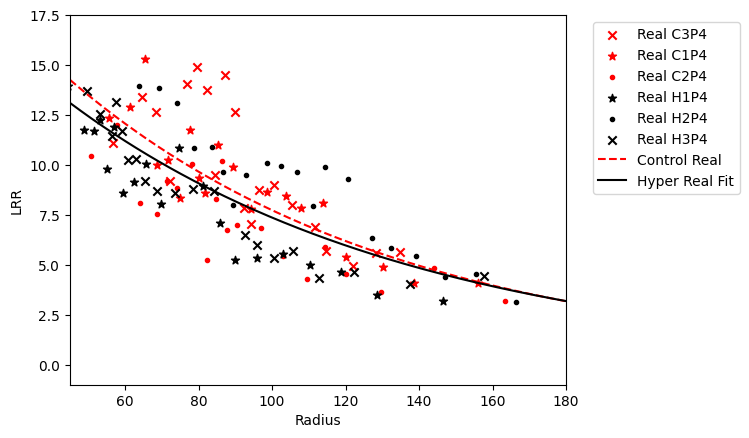

In [147]:
#plt.scatter(c3p4gr,c3p4gl, c='b', marker='x', label='Generated C3P4')
plt.scatter(c3p4rr,c3p4rl, c='r', marker='x', label='Real C3P4')
#plt.scatter(c1p4gr,c1p4gl, c='b', marker='*', label='Generated C1P4')
plt.scatter(c1p4rr,c1p4rl, c='r', marker='*', label='Real C1P4')
#plt.scatter(c2p4gr,c2p4gl, c='b', marker='.', label='Generated C2P4')
plt.scatter(c2p4rr,c2p4rl, c='r', marker='.', label='Real C2P4')
#plt.scatter(h1p4gr,h1p4gl, c='g', marker='*', label='Generated H1P4')
plt.scatter(h1p4rr,h1p4rl, c='k', marker='*', label='Real H1P4')
#plt.scatter(h2p4gr,h2p4gl, c='g', marker='.', label='Generated H2P4')
plt.scatter(h2p4rr,h2p4rl, c='k', marker='.', label='Real H2P4')
#plt.scatter(h3p4gr,h3p4gl, c='g', marker='x', label='Generated H3P4')
plt.scatter(h3p4rr,h3p4rl, c='k', marker='x', label='Real H3P4')
plt.plot(x_range, crlrr_fit, color='red', linestyle='--', label='Control Real')
plt.plot(x_range, hrlrr_fit, color='k', linestyle='-', label='Hyper Real Fit')
#plt.plot(x_range, cglrr_fit, color='b', linestyle='--', label='Control Gen Fit')
#plt.plot(x_range, hglrr_fit, color='g', linestyle='-', label='Hyper Gen Fit')
plt.ylabel('LRR')
plt.xlabel('Radius')
plt.xlim([45, 180])
plt.ylim([-1,17.5])
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

# Whole Lung

In [137]:
c1p4_whole = lobeInput('m1p4_060407',44,45)
c2p4_whole = lobeInput('m2p4_060407',515,727)
c3p4_whole = lobeInput('m3p4_060407',326,939)
h1p4_whole = lobeInput('m1p4_053007',23,1809)
h2p4_whole = lobeInput('m2p4_053007',184,1240)
h3p4_whole = lobeInput('m1p4_053107',43,2565)

In [140]:
c1p4wr,c1p4wl = bintoPlot(c1p4_whole,control1p4,'Length/Radius')
c2p4wr,c2p4wl = bintoPlot(c2p4_whole,control2p4,'Length/Radius')
c3p4wr,c3p4wl = bintoPlot(c3p4_whole,control3p4,'Length/Radius')
h1p4wr,h1p4wl = bintoPlot(h1p4_whole,hyper1p4,'Length/Radius')
h2p4wr,h2p4wl = bintoPlot(h2p4_whole,hyper2p4,'Length/Radius')
h3p4wr,h3p4wl = bintoPlot(h3p4_whole,hyper3p4,'Length/Radius')

In [141]:
controlwlrr = np.concatenate((c1p4wl,c2p4wl,c3p4wl),axis=0)
controlwr = np.concatenate((c1p4wr,c2p4wr,c3p4wr),axis=0)
hypwlrr = np.concatenate((h1p4wl,h2p4wl,h3p4wl),axis=0)
hypwr = np.concatenate((h1p4wr,h2p4wr,h3p4wr),axis=0)

paramscwlrr, _ = curve_fit(exponential, controlwr, controlwlrr,p0=[10, 0.01])
paramshwlrr, _ = curve_fit(exponential, hypwr, hypwlrr,p0=[10, 0.01])

print(paramscwlrr)

x_range = np.linspace(45,400, 355)

cwlrr_fit = exponential(x_range, *paramscwlrr)
hwlrr_fit = exponential(x_range, *paramshwlrr)

[2.60616670e+01 1.16828857e-02]


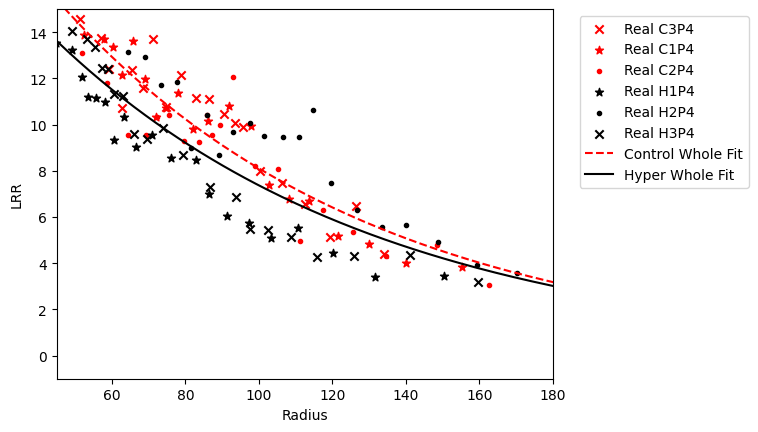

In [143]:
plt.scatter(c3p4wr,c3p4wl, c='r', marker='x', label='Real C3P4')
plt.scatter(c1p4wr,c1p4wl, c='r', marker='*', label='Real C1P4')
plt.scatter(c2p4wr,c2p4wl, c='r', marker='.', label='Real C2P4')
plt.scatter(h1p4wr,h1p4wl, c='k', marker='*', label='Real H1P4')
plt.scatter(h2p4wr,h2p4wl, c='k', marker='.', label='Real H2P4')
plt.scatter(h3p4wr,h3p4wl, c='k', marker='x', label='Real H3P4')
plt.plot(x_range, cwlrr_fit, color='red', linestyle='--', label='Control Whole Fit')
plt.plot(x_range, hwlrr_fit, color='k', linestyle='-', label='Hyper Whole Fit')
plt.ylabel('LRR')
plt.xlabel('Radius')
plt.xlim([45, 180])
plt.ylim([-1,15])
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

try raw data
focus on left lobe
on vs off principle pathway
use all mice